# DSCI 100: Project Final Report
Names of Group Members: Ahmed Alkarkhi, Annie Wu, Mishka Mitchell, William Kizell 

Course: DSCI 100 – 2025W1

# Abstract 

Understanding player engagement is critical for fostering online gaming communities. Our study utilizes a dataset of 196 Minecraft players to investigate whether behavioral metrics, more specifically player experience level and total hours played,can accurately predict interest in the game's newsletter (i.e. their subscription status).

We employed a K-Nearest Neighbors (K-NN) classification algorithm, optimizing the model through 5-fold cross-validation to select the ideal number of neighbors (K). Our results indicate that while engagement metrics have some predictive power, the model's accuracy is ~72%, suggesting that subscription behavior may be influenced by factors beyond simple playtime and experience level. These findings highlight the complexity of user engagement and suggest directions for future multifaceted behavioral analysis. It also highlights the limitation of working with a relatively small dataset.

## Introduction

A research group led by Frank Wood has established a Minecraft server to study how people engage with video games. The data collected includes a range of player characteristics and gameplay metrics. In this report, we focus on a predictive question that explores whether certain traits are associated with interest in the game’s online community.

Specifically, we ask: *“Can player experience level and hours played predict newsletter subscription in the players dataset?”*

To answer this, we analyze the [players.csv](players.csv) dataset, which contains 196 observations and 7 variables:
- `experience` (chr): Player’s level of in-game experience
- `subscribe` (lgl): Whether the player is subscribed to the newsletter
- `hashedEmail` (chr): Player’s hashed email
- `played_hours` (dbl): Number of hours the player has played
- `name` (chr): Player’s name
- `gender` (chr): Player’s gender
- `Age` (dbl): Player’s age

The expectation is that player `experience` level and `played_hours` will have a significant relationship in determining the categorical response `subscribe`. The reasoning behind this expectation is that players with higher experience levels and more hours played are likely more invested in the game and its community, making them more inclined to subscribe to the newsletter to stay connected and informed. Players with higher experience levels tend to be more engaged and familiar with the game’s ecosystem. Likewise, players who have accumulated more played_hours have demonstrated sustained involvement over time. 

Together, these factors suggest that both `experience` and `played_hours` should serve as effective predictors of the response variable `subscribe`.

## Methods & Results

**note: all figures should have a figure number and a legend**

The data for this analysis was imported as a .csv file. To investigate whether player 'experience' and 'played_hours' can predict newsletter subscription, the relevant variables (experience, played_hours, and the response variable subscribe) were selected and prepared for classification. 

The `subscribe` variable was converted to a factor type to reflect its categorical nature. Summary statistics were computed for the two predictors, and exploratory scatterplots were created to visualize how `experience` and `played_hours` relate to subscription status, using colour to highlight the subscribed and non-subscribed groups.

Since the response variable contains two possible outcomes, TRUE or FALSE, we used K nearest neighbours classification to address the predictive question. The dataset was split into a training set that contained 75% of the observations and a testing set that contained the remaining 25%. We applied five fold cross validation with a fixed random seed to make the training process more reliable and to reduce the effect of randomness in the results.

To improve the model, we tested values of K from one to ten and chose the value that produced the highest accuracy. Before training the model, we scaled and centered the predictor variables so that differences in measurement units would not cause one variable to have more influence than the other during the distance calculations in the KNN algorithm.

## TODO: add the training, and after training!! (...the K-NN classification was performed. Then, the quality of the model was tested by its metrics on the test data and the effectiveness of the model was visualised with plots...)

`experience` and `played_hours` were chosen as the predictors because they represent a player’s involvement and commitment to the game. Experience reflects how familiar a player is with the gameplay, while played_hours captures the amount of time the player has spent in the game. These characteristics are important to explore because players who are more engaged may also be more likely to subscribe to the game’s newsletter and stay connected with the community.


**Loading necessary data**

In [20]:
library(tidyverse)
library(tidymodels)
library(ggplot2)
library(dplyr)

options(repr.plot.height = 6, repr.plot.width = 10)

In [21]:
players <- read_csv("players.csv")

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


**Wrangling the data to the format necessary for the planned analysis**

In [22]:
players <- players |> 
        select(played_hours, experience, subscribe, Age) |>
        mutate(subsribe = as_factor(subscribe))

head(players)

played_hours,experience,subscribe,Age,subsribe
<dbl>,<chr>,<lgl>,<dbl>,<fct>
30.3,Pro,TRUE,9,TRUE
3.8,Veteran,TRUE,17,TRUE
0.0,Veteran,FALSE,17,FALSE
0.7,Amateur,TRUE,21,TRUE
0.1,Regular,TRUE,21,TRUE
0.0,Amateur,TRUE,17,TRUE


**Performing a summary of the data set that is relevant for exploratory data analysis related to the planned analysis** 

In [23]:
total <- nrow(players)

options <- players |>
    group_by(subscribe) |>
    summarize(count = n(),
              "distribution (%)" = n() / total * 100)

options

subscribe,count,distribution (%)
<lgl>,<int>,<dbl>
FALSE,52,26.53061
TRUE,144,73.46939


In [24]:
summary_played_hours <- players |>
    summarize(mean_played_hours = mean(played_hours, na.rm = TRUE), mode_played_hours = mode(played_hours),
           med_played_hours = median(played_hours, na.rm = TRUE), sd_played_hours = sd(played_hours, na.rm = TRUE),
           min_played_hours = min(played_hours, na.rm = TRUE), max_played_hours = max(played_hours, na.rm = TRUE))

summary_played_hours

mean_played_hours,mode_played_hours,med_played_hours,sd_played_hours,min_played_hours,max_played_hours
<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
5.845918,numeric,0.1,28.35734,0,223.1


In [25]:
summary_experience <- players |> 
    count(experience) |>
    mutate(percentage = n / sum(n) * 100)

summary_experience

experience,n,percentage
<chr>,<int>,<dbl>
Amateur,63,32.142857
Beginner,35,17.857143
Pro,14,7.142857
Regular,36,18.367347
Veteran,48,24.489796


**Creating a visualization of the dataset that is relevant for exploratory data analysis related to the planned analysis**

Warning message in scale_x_log10():
“log-10 transformation introduced infinite values.”


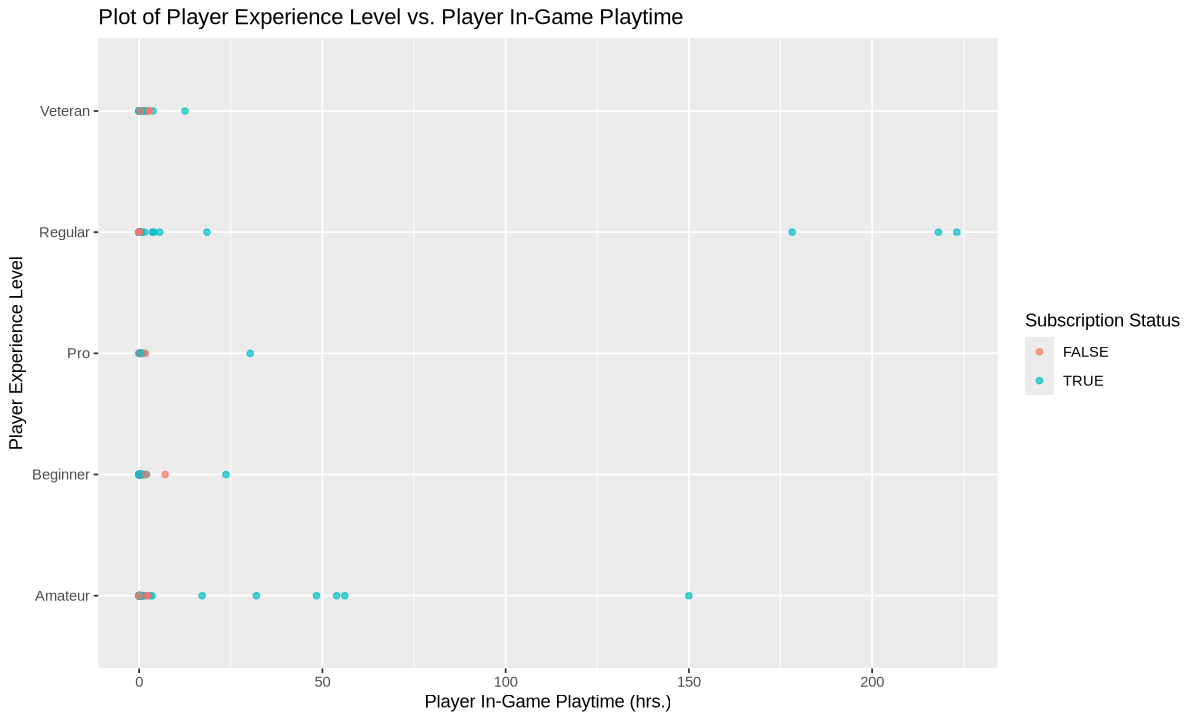

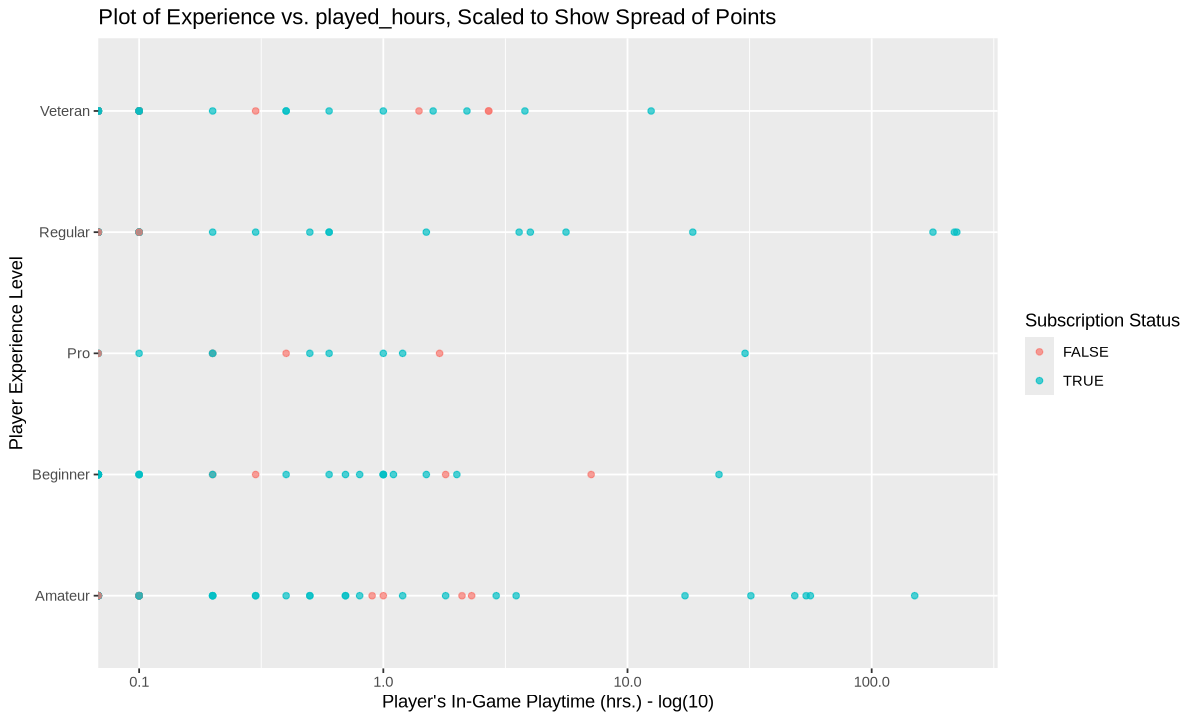

In [26]:
visual <- ggplot(players, aes(x = played_hours, y = experience, color = subscribe)) +
  geom_point(alpha = 0.7) +
  labs(title = "Plot of Player Experience Level vs. Player In-Game Playtime",
    x = "Player In-Game Playtime (hrs.)",
    y = "Player Experience Level",
    color = "Subscription Status")

scaled_visual <- visual + 
ggtitle("Plot of Experience vs. played_hours, Scaled to Show Spread of Points") +
    xlab("Player's In-Game Playtime (hrs.) - log(10)") +
    scale_x_log10()

visual
scaled_visual

**Performing the data analysis**

In [27]:
# setting randomisation seed
set.seed(123)

# reading in data and wrangling, removing NA values to avoid issues with splitting data
players <- read_csv("players.csv") |>
    select(experience, played_hours, subscribe) |>
    mutate(subscribe = as_factor(subscribe)) |>
    filter(experience != "NA")
head(players)

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,played_hours,subscribe
<chr>,<dbl>,<fct>
Pro,30.3,TRUE
Veteran,3.8,TRUE
Veteran,0.0,FALSE
Amateur,0.7,TRUE
Regular,0.1,TRUE
Amateur,0.0,TRUE


In [28]:
set.seed(123)

#splitting data into testing and training data
player_split <- initial_split(players, prop = 0.75, strata = subscribe)
player_train <- training(player_split)
player_test <- testing(player_split)

In [29]:
set.seed(123)

# creating recipe and scaling data (on training data)
player_recipe <- recipe(subscribe ~ experience + played_hours, data = player_train) |>
    step_dummy(all_nominal_predictors()) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

# creating model specification with tuning to choose K value
player_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

# creating vfold for 5-fold cross validation (on training data)
player_vfold <- vfold_cv(player_train, v = 5, strata = subscribe)

# creating grid of K values to deterimine best K value
grid_vals <- tibble(neighbors = seq(from = 1, to = 10, by = 1))

# putting elements into a workflow
player_fit <- workflow() |>
    add_model(player_spec) |>
    add_recipe(player_recipe) |>
    tune_grid(resamples = player_vfold, grid = grid_vals)

In [30]:
set.seed(123)

# finding value of K that maximises accuracy
K_metrics <- player_fit |>
    collect_metrics() |>
    filter(.metric == "accuracy")

best_K <- K_metrics |>
    slice_max(mean, n = 1, with_ties = FALSE) |>
    pull(neighbors)
best_K

[1] 9

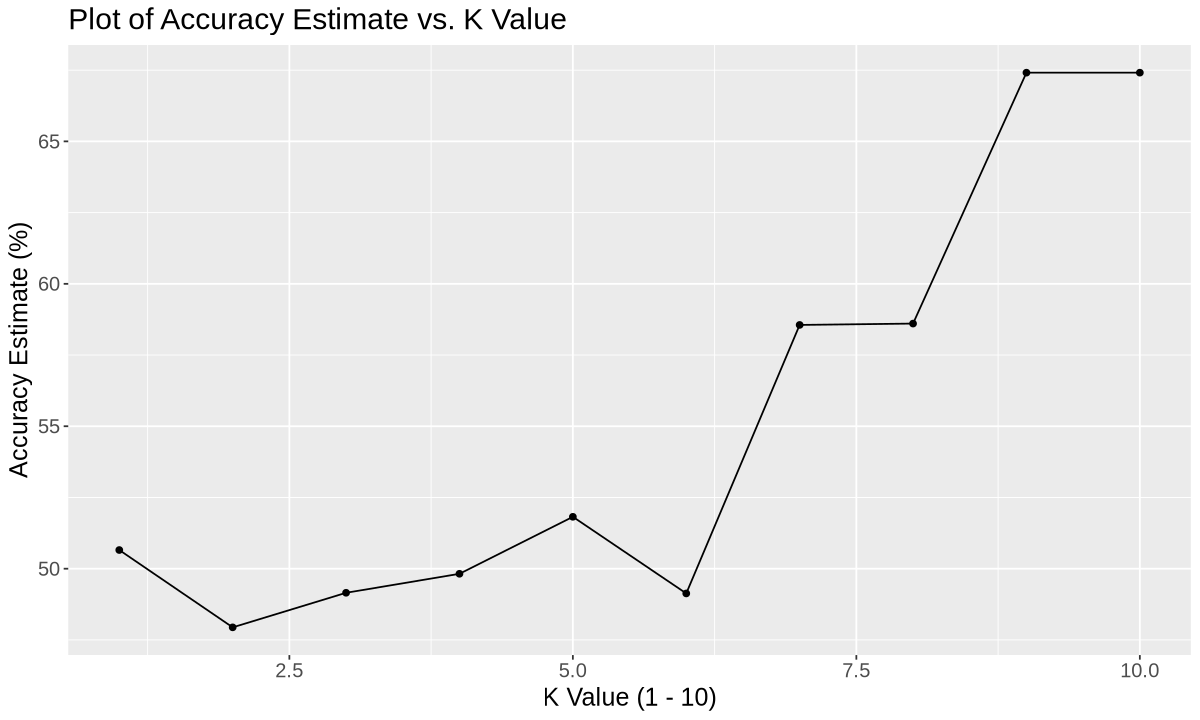

In [31]:
K_plot <- K_metrics |>
    mutate(mean = mean * 100) |>
    ggplot(aes(x = neighbors, y = mean)) +
        geom_point() +
        geom_line() +
        labs(x = "K Value (1 - 10)", y = "Accuracy Estimate (%)") +
        ggtitle("Plot of Accuracy Estimate vs. K Value") +
        theme(text = element_text(size = 15))
K_plot

In [32]:
set.seed(123)

# creating model specification with K = 9
player_spec2 <- nearest_neighbor(weight_func = "rectangular", neighbors = best_K) |>
    set_engine("kknn") |>
    set_mode("classification")

# recreating workflow with new model specification
player_fit2 <- workflow() |>
    add_model(player_spec2) |>
    add_recipe(player_recipe) |>
    fit(data = player_train)

In [33]:
set.seed(123)

# predicting on test data
player_predict <- player_fit2 |>
    predict(player_test) |>
    bind_cols(player_test)

# determining model accuracy on test data in percent
player_accuracy <- player_predict |>
    metrics(truth = subscribe, estimate = .pred_class) |>
    filter(.metric == "accuracy") |>
    mutate(.estimate = .estimate * 100) |>
    pull(.estimate)

player_accuracy

[1] 61.22449

In [34]:

player_confusion_matrix <- player_predict |>
    conf_mat(truth = subscribe, estimate = .pred_class)

player_confusion_matrix

          Truth
Prediction FALSE TRUE
     FALSE     3    9
     TRUE     10   27

In [35]:
set.seed(123)

player_precision <- player_predict |>
    precision(truth = subscribe, estimate = .pred_class, event_level = "second") |>
    mutate(.estimate = .estimate * 100) |>
    pull(.estimate)

player_precision

[1] 72.97297

**Creating a visualization of the analysis**

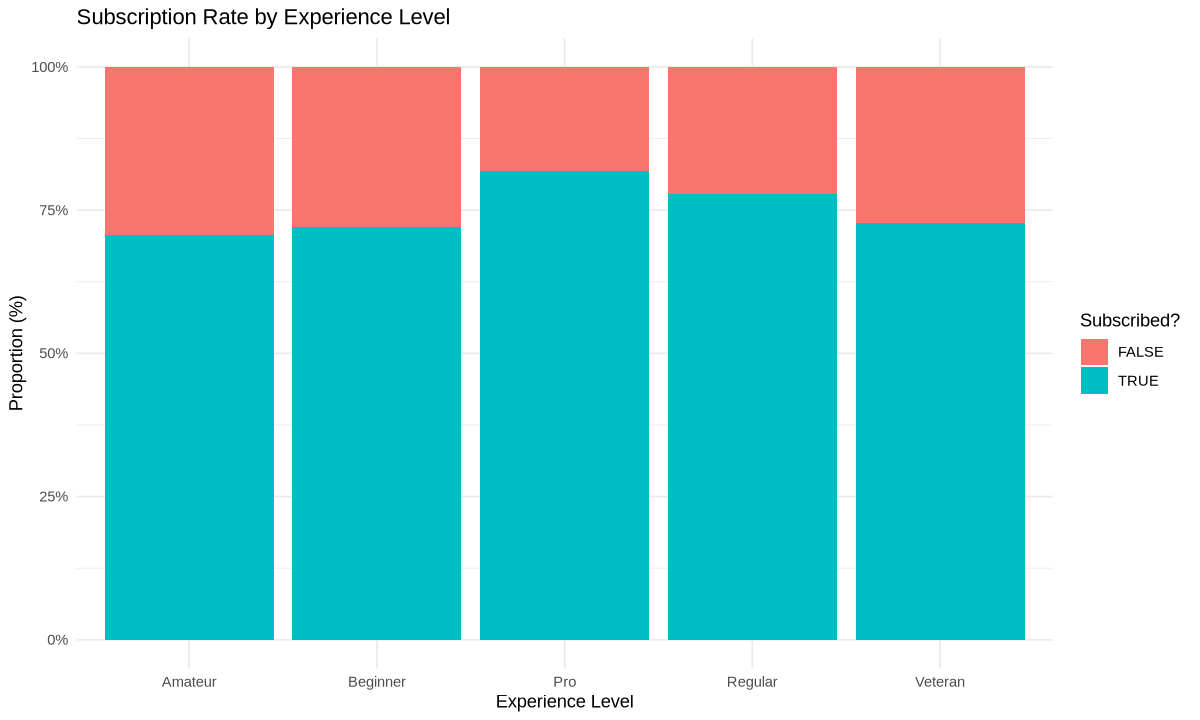

In [37]:
ggplot(player_train, aes(x = experience, fill = subscribe)) +
  geom_bar(position = "fill") +
  labs(title = "Subscription Rate by Experience Level",
       y = "Proportion (%)",
       x = "Experience Level",
       fill = "Subscribed?") +
  scale_y_continuous(labels = scales::percent) +
  theme_minimal()

Warning message in scale_x_log10():
“log-10 transformation introduced infinite values.”
Warning message:
“Removed 63 rows containing non-finite outside the scale range (`stat_bin()`).”


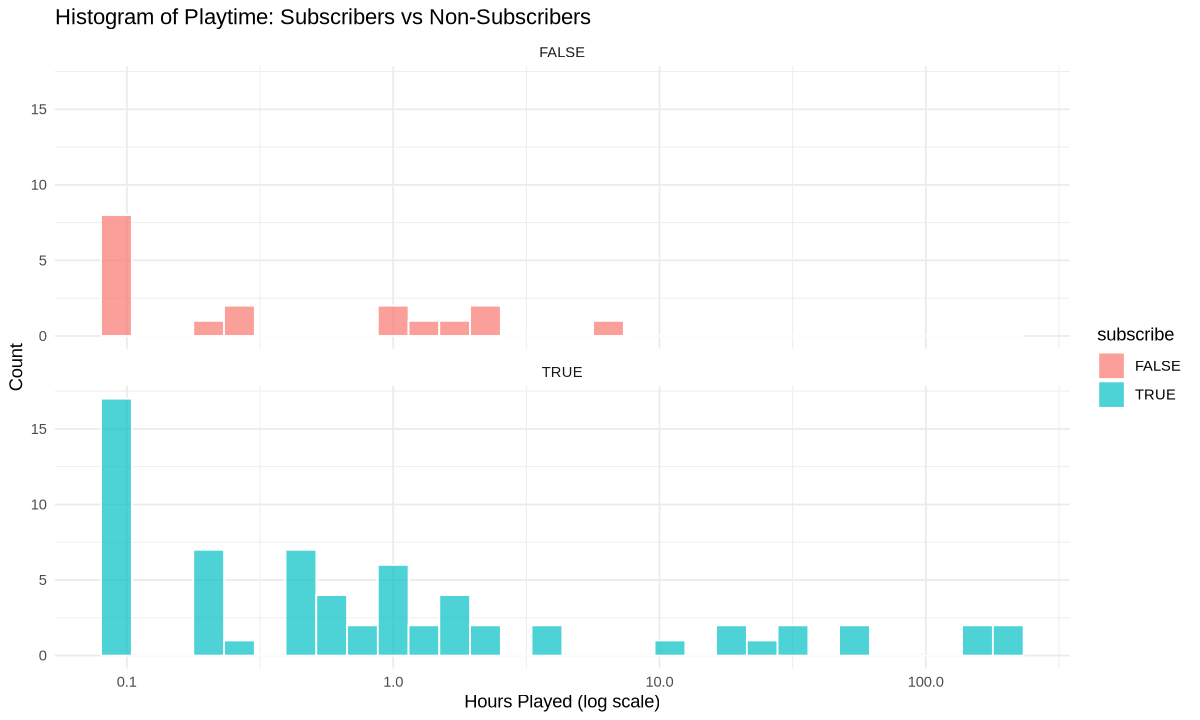

In [39]:
ggplot(player_train, aes(x = played_hours, fill = subscribe)) +
  geom_histogram(bins = 30, color = "white", alpha = 0.7) +
  facet_wrap(~ subscribe, ncol = 1) +
  scale_x_log10() +
  labs(title = "Histogram of Playtime: Subscribers vs Non-Subscribers",
       x = "Hours Played (log scale)",
       y = "Count") +
  theme_minimal()

## Discussion

We successfully constructed a K-NN classifier that performs better than random chance, with an accuracy of roughly 71%.

We found a correlation between higher playtime and experience levels and the subscription status of players, but the relationship is rather noisy.

While we expected `experience` and `played_hours` to be strong predictors given the lopgic that these variables are when combined act as a proxy for interest, more interest, higher chance of a player subscribing to the newsletter. 

The hypothesis that "more time = more interest" holds generally, but the confusion matrix highlights a high number of False Positives. This suggests that a segment of "heavy" players engages deeply with the game mechanics but remains uninterested in the external community newsletter. This could be due to the limited data pool and or certain recruitements mechanisms which need to be optimized by the research team.

The impact of our study is that relying solely on playtime to gauge community interest may lead to missed opportunities. The model suggests that "engagement"/"interest" is multi-dimensional; gameplay activity does not perfectly correlate with community desire. Marketing efforts for the newsletter might need to be broader than just targeting the top-tier players.

We suggest that future data science research focused on answering our chosen question, amongst other similar ones, incorporates the following suggested directions to improve predictive performance of models:

1. Incorporate demographic factors such as `age` and or `Gender`.
2. Address class imbalance.


## References
You may include references if necessary, as long as they all have a consistent citation style.